# AutoEncodeur - Projet ML - Antoine Théologien & Célian Vasson

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from module import *
from mltools import *
from loss import *

output_dir = "../Rapport/Images"
os.makedirs(output_dir, exist_ok=True)

def load_usps(fn):
    with open(fn, "r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)
    return tmp[:, 1:], tmp[:, 0].astype(int)

def get_usps(l, datax, datay):
    if type(l) != list:
        resx = datax[datay == l, :]
        resy = datay[datay == l]
        return resx, resy
    tmp = list(zip(*[get_usps(i, datax, datay) for i in l]))
    tmpx, tmpy = np.vstack(tmp[0]), np.hstack(tmp[1])
    return tmpx, tmpy

def SGD(network, datax, datay, loss, batch_size=10, lr=0.01, epochs=500):

    optimizer = Optim(network, loss, eps=lr)
    losses = []

    for epoch in range(epochs):
        indices = np.random.permutation(len(datax))  
        batch_losses = []

        for i in range(0, len(datax), batch_size):
            batch_x = datax[indices[i:i + batch_size]]
            batch_y = datay[indices[i:i + batch_size]]

            optimizer.step(batch_x, batch_y)  

            y_hat = network.forward(batch_x)
            batch_loss = loss.forward(batch_y, y_hat).mean()
            batch_losses.append(batch_loss)

        losses.append(np.mean(batch_losses))  

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss : {losses[-1]:.4f}")

    return losses, network


encodeur = Sequentiel(
    Linear(256, 100),
    TanH(),
    Linear(100, 10),
    TanH()
)

decodeur = Sequentiel(
    Linear(10, 100),
    TanH(),
    Linear(100, 256),
    Sigmoide()
)

autoencoder = Sequentiel(encodeur, decodeur)


train_file = "../data/USPS_train.txt"
test_file = "../data/USPS_test.txt"


Epoch 0, Loss : 0.6344
Epoch 50, Loss : -1.4290
Epoch 100, Loss : -1.7121
Epoch 150, Loss : -1.7325
Epoch 200, Loss : -1.8650
Epoch 250, Loss : -1.9624
Epoch 300, Loss : -2.0034
Epoch 350, Loss : -2.0159
Epoch 400, Loss : -2.0691
Epoch 450, Loss : -2.0829
Epoch 500, Loss : -2.0882
Epoch 550, Loss : -2.1245
Epoch 600, Loss : -1.9825
Epoch 650, Loss : -2.1221
Epoch 700, Loss : -2.1308
Epoch 750, Loss : -2.0965
Epoch 800, Loss : -2.1343
Epoch 850, Loss : -2.1397
Epoch 900, Loss : -2.1491
Epoch 950, Loss : -2.1478


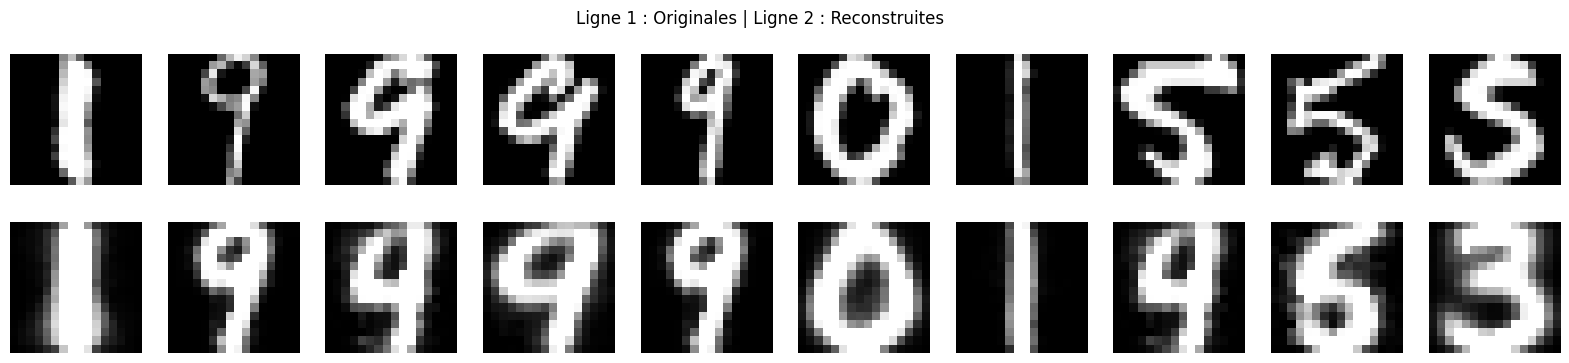

In [5]:
datax, datay = load_usps(train_file)
X_train, X_test, y_train, y_test = train_test_split(datax, datay, test_size=0.2, random_state=42)

loss_function = BinaryCrossEntropyLoss()
losses, trained_autoencoder = SGD(autoencoder, X_train, X_train, loss_function,
                                  batch_size=64, lr=0.01, epochs=1000)

n = 10
indices = np.random.choice(len(X_test), n)
X_sample = X_test[indices]
X_reconstructed = autoencoder.forward(X_sample)

fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
for i in range(n):
    axes[0, i].imshow(X_sample[i].reshape(16, 16), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(X_reconstructed[i].reshape(16, 16), cmap="gray")
    axes[1, i].axis("off")

plt.suptitle("Ligne 1 : Originales | Ligne 2 : Reconstruites")
# output_path = os.path.join(output_dir, "autoecodeur.png")
# plt.savefig(output_path, dpi=300)
plt.show()


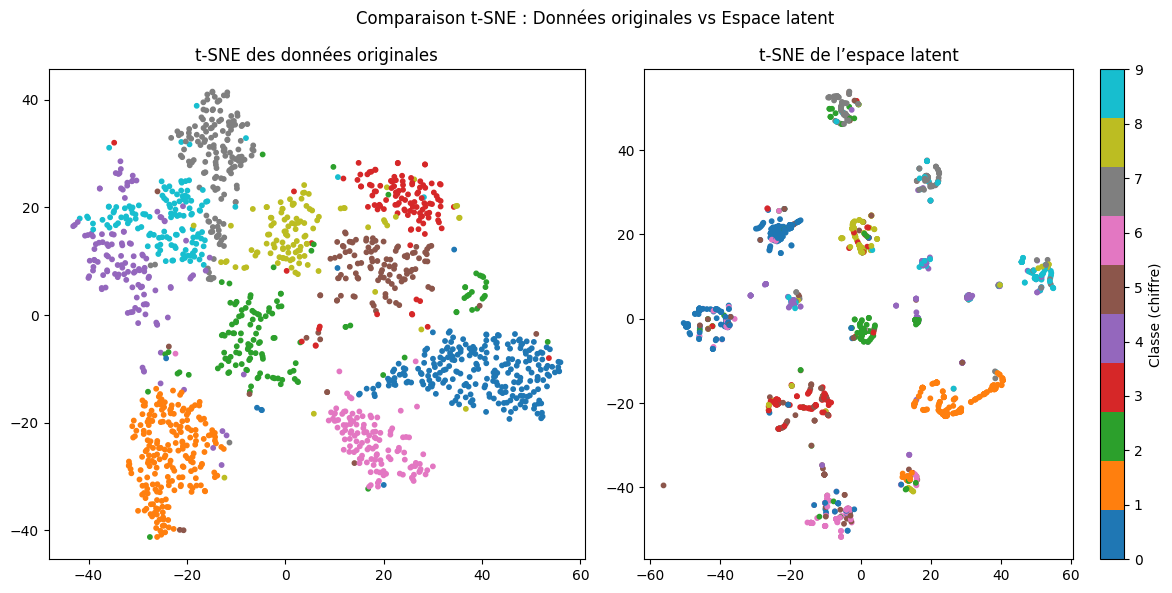

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_orig_proj = TSNE(n_components=2, random_state=42).fit_transform(X_test)

X_latent = encodeur.forward(X_test)
X_latent_proj = TSNE(n_components=2, random_state=42).fit_transform(X_latent)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

scatter1 = axes[0].scatter(X_orig_proj[:, 0], X_orig_proj[:, 1], c=y_test, cmap="tab10", s=10)
axes[0].set_title("t-SNE des données originales")

scatter2 = axes[1].scatter(X_latent_proj[:, 0], X_latent_proj[:, 1], c=y_test, cmap="tab10", s=10)
axes[1].set_title("t-SNE de l’espace latent")

plt.suptitle("Comparaison t-SNE : Données originales vs Espace latent")

plt.colorbar(scatter2, ax=axes[1], label="Classe (chiffre)")

plt.tight_layout()
# output_path = os.path.join(output_dir, "t-sne.png")
# plt.savefig(output_path, dpi=300)
plt.show()


Adjusted Rand Index (ARI) : 0.4717
Silhouette Score : 0.7418


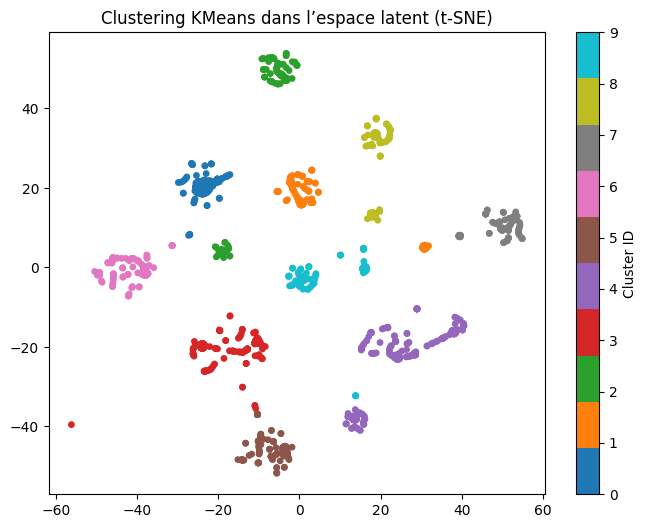

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_latent = encodeur.forward(X_test)

kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_latent)

ari = adjusted_rand_score(y_test, cluster_labels)
silhouette = silhouette_score(X_latent, cluster_labels)

print(f"Adjusted Rand Index (ARI) : {ari:.4f}")
print(f"Silhouette Score : {silhouette:.4f}")

X_proj = TSNE(n_components=2, random_state=42).fit_transform(X_latent)
plt.figure(figsize=(8, 6))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=cluster_labels, cmap="tab10", s=15)
plt.title("Clustering KMeans dans l’espace latent (t-SNE)")
plt.colorbar(label="Cluster ID")
plt.show()


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools

datax, datay = load_usps(train_file)
X_train, X_test, y_train, y_test = train_test_split(datax, datay, test_size=0.2, random_state=42)

learning_rates = [0.001, 0.01, 0.05]
batch_sizes = [32,64,128]
epochs = 1000

results = []

for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    print(f"Training AE with lr={lr}, batch_size={batch_size}")

    encodeur = Sequentiel(
    Linear(256, 100),
    TanH(),
    Linear(100, 10),
    TanH()
    )

    decodeur = Sequentiel(
        Linear(10, 100),
        TanH(),
        Linear(100, 256),
        Sigmoide()
    )

    autoencoder = Sequentiel(encodeur, decodeur)

    loss_fn = BinaryCrossEntropyLoss()
    _, _ = SGD(autoencoder, X_train, X_train, loss_fn, batch_size=batch_size, lr=lr, epochs=epochs)

    X_latent = encodeur.forward(X_test)

    kmeans = KMeans(n_clusters=10, random_state=42)
    labels = kmeans.fit_predict(X_latent)

    silhouette = silhouette_score(X_latent, labels)
    print(f"Silhouette score: {silhouette:.4f}")

    results.append({
        "lr": lr,
        "batch_size": batch_size,
        "silhouette": silhouette
    })

results = sorted(results, key=lambda x: -x["silhouette"])
print("\nTop configs :")
for r in results:
    print(f"lr={r['lr']}, batch={r['batch_size']} → silhouette={r['silhouette']:.4f}")


Training AE with lr=0.001, batch_size=32
Epoch 0, Loss : 2.1809
Epoch 50, Loss : -0.5652
Epoch 100, Loss : -0.5821
Epoch 150, Loss : -0.8095
Epoch 200, Loss : -0.8799
Epoch 250, Loss : -0.8997
Epoch 300, Loss : -0.9180
Epoch 350, Loss : -0.9882
Epoch 400, Loss : -1.1614
Epoch 450, Loss : -1.3238
Epoch 500, Loss : -1.4072
Epoch 550, Loss : -1.4601
Epoch 600, Loss : -1.5352
Epoch 650, Loss : -1.6187
Epoch 700, Loss : -1.7056
Epoch 750, Loss : -1.7888
Epoch 800, Loss : -1.8365
Epoch 850, Loss : -1.8759
Epoch 900, Loss : -1.8885
Epoch 950, Loss : -1.9326
Silhouette score: 0.7199
Training AE with lr=0.001, batch_size=64
Epoch 0, Loss : 2.7781
Epoch 50, Loss : -0.6703
Epoch 100, Loss : -0.8893
Epoch 150, Loss : -0.9270
Epoch 200, Loss : -0.9763
Epoch 250, Loss : -1.0148
Epoch 300, Loss : -1.0391
Epoch 350, Loss : -1.0964
Epoch 400, Loss : -1.1837
Epoch 450, Loss : -1.2521
Epoch 500, Loss : -1.3220
Epoch 550, Loss : -1.3549
Epoch 600, Loss : -1.3869
Epoch 650, Loss : -1.3937
Epoch 700, Loss :